#IMDB REVIEW CLASSIFICATION USING FastAI

#IMDB Review Classification

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

###Data Preparation

In [30]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/root/.fastai/data/imdb_sample/data_save.pkl')]

In [31]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [32]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [0]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

In [0]:
data_lm.save()

In [0]:
data = load_data(path)

###Tokenization

In [36]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative
"xxbos xxmaj how viewers react to this new "" adaption "" of xxmaj shirley xxmaj jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one",negative


###Numericalization

In [37]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

In [38]:
data.train_ds[0][0]

Text xxbos i do n't think most of us would tend to apply the term " must - see " to action films , but i was very impressed at how good this film was and it deservedly gets the " must - see " xxunk from me . 
 
  xxmaj mandy played by xxmaj xxunk xxmaj lee ( daughter of the late and great xxmaj bruce xxmaj lee and sister of the late xxmaj brandon xxmaj lee ) is xxunk by xxmaj martin , a professional thief to help pull off a diamond heist at a museum for a criminal syndicate , and get rewarded xxunk for it . xxmaj little do they know that another pair of thieves ( xxmaj lucy and xxmaj tommy , a pair of xxunk ) , who were xxunk earlier by xxmaj mandy and xxmaj martin to get in on the deal , are also planning to steal the diamond . 
 
  xxmaj how each pair of thieves plans out the heist is a xxunk to watch . xxmaj things go awry , as xxmaj martin and xxmaj mandy xxunk find themselves a step behind xxmaj lucy and xxmaj tommy . 
 
  xxmaj you 'll find yourself rooting for these thieves as t

In [39]:
data.train_ds[0][0].data[:10]

array([   2,   18,   59,   34,  124,  110,   13,  196,   73, 1450])

In [0]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

###Language Model

In [0]:
bs=48

In [42]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/models'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [43]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

In [0]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [47]:
data_lm.show_batch()

idx,text
0,"current , which it would n't . \n \n xxmaj it would be possible with a dozen large car batteries and an xxunk , but that system would n't fit into the case . xxmaj sorry to be anal , but this is n't even close to being plausible . xxmaj the rest of the film was n't a great deal better and i 'm left wondering why the"
1,"the most interesting thing in this film . despite its short running time ( just over an hour ) i think the reason that this film was rarely seen on xxup tv was that after 20 minutes you begin to lose patience with it . xxmaj as good as the talk is , i just wished someone would do something . xxmaj when it finally did happen , in the"
2,"a slimy corporate lawyer ) . xxmaj the slim story , about a grueling audition for a xxmaj broadway show which turns into a therapy session for the actor - dancer - singers , is pushed right up on us , with loud , brassy talents playing to the rafters . xxmaj nothing is modulated or subtle , particularly a laughable subplot about a ex - dancer returning to the"
3,"pooja xxmaj singh ( xxmaj kareena xxmaj kapoor ) , who 's not exactly who she seems , the meek and sweet natured hottie . xxmaj she engages xxmaj jimmy 's services for her boss , mobster xxmaj bhaiyyaji ( xxmaj anil xxmaj kapoor ) , who probably gets most of the laughs as he speaks broken xxmaj english and phrases must like how an ah - xxunk does it"
4,slow and sadly not funny . xxmaj just plain boring xxunk running into each other and trying to make us laugh .. not working . \n \n xxmaj maybe next time knox . \n \n xxmaj maybe re - cutting this movie and adding better scenes would do a lot of healing but for now its just not good . xxbos xxmaj during the xxmaj civil xxmaj war


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


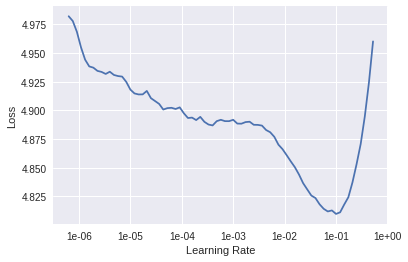

In [50]:
learn.recorder.plot(skip_end=15)

In [51]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.216326,4.056893,0.293112,1:25:00


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [55]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.871475,3.797189,0.322009,1:34:47


In this case I changed the cycle length parameter of the fit_one_cycle method to 1 from 10 since I face some GPU performance and memory allocation problems.

In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [66]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was so EXTREMELY funny , and it was fun to sit down and watch it again . 
 
  i never heard of M. E. Draft , Richard Pryor , Cary Grant
I liked this movie because it was a great movie . i a love story and i adore it so well . i think this movie has a perfect twist for Dennis Quaid , he was great , and in that movie he


In [0]:
learn.save_encoder('fine_tuned_enc')


###Classifier

In [0]:
path = untar_data(URLs.IMDB)

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [71]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj some have praised xxunk :- xxmaj the xxmaj lost xxmaj xxunk as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack",neg
"xxbos xxup anchors xxup aweigh sees two eager young sailors , xxmaj joe xxmaj brady ( xxmaj gene xxmaj kelly ) and xxmaj clarence xxmaj doolittle / xxmaj brooklyn ( xxmaj frank xxmaj sinatra ) , get a special four - day shore leave . xxmaj eager to get to the girls , particularly xxmaj joe 's xxmaj lola , neither xxmaj joe nor xxmaj brooklyn figure on the interruption",pos
"xxbos xxup myra xxup breckinridge is one of those rare films that established its place in film history immediately . xxmaj praise for the film was absolutely nonexistent , even from the people involved in making it . xxmaj this film was loathed from day one . xxmaj while every now and then one will come across some maverick who will praise the film on philosophical grounds ( aggressive feminism",neg
"xxbos xxmaj god ! xxmaj zorro has been the the subject of about as many movies as xxmaj tarzan , and probably had about as many actors in the title role . \n \n xxmaj this xxmaj serial is one of my own personal favourites , and as previously stated , it is one of the xxmaj top 5 xxmaj sound xxmaj serials . xxmaj oddly enough , this",pos


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [73]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


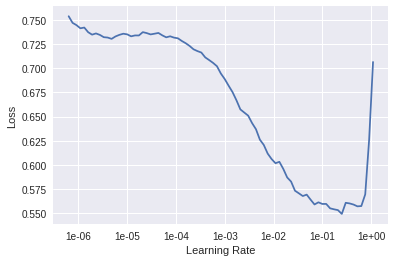

In [74]:
learn.recorder.plot()

In [75]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.339996,0.252327,0.897360,11:19


In [0]:
learn.save('first')

In [77]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i vowed a long time ago to xxup never , xxup ever watch a movie that has xxup anyone who xxup ever was a regular cast member of " xxmaj saturday xxmaj night xxmaj live " . i did n't rent " xxmaj corky xxmaj romano " but i was forced by my unfailing good manners to watch it for half an hour . xxmaj then my good manners failed . xxmaj stupid , not funny . xxmaj tedious , not hilarious . xxmaj bad , not good . xxmaj that in a nutshell is all i can say for this video .,xxbos xxmaj the worst kind of film . xxmaj basically , the xxup us xxmaj declaration of xxmaj independence was replaced with a plasma screen and this fooled the museum 's security for several days . xxmaj eh ? 
 
  xxmaj the plasma screen that would theoretically run for less than 2 seconds off that watch battery , assuming it had a low enough internal resistance to deliver the required current , which it would n't . 
 
  xxmaj it would be p

In [78]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.292317,0.205541,0.918240,12:48


In [0]:
learn.save('second')

In [80]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i vowed a long time ago to xxup never , xxup ever watch a movie that has xxup anyone who xxup ever was a regular cast member of " xxmaj saturday xxmaj night xxmaj live " . i did n't rent " xxmaj corky xxmaj romano " but i was forced by my unfailing good manners to watch it for half an hour . xxmaj then my good manners failed . xxmaj stupid , not funny . xxmaj tedious , not hilarious . xxmaj bad , not good . xxmaj that in a nutshell is all i can say for this video .,xxbos xxmaj the worst kind of film . xxmaj basically , the xxup us xxmaj declaration of xxmaj independence was replaced with a plasma screen and this fooled the museum 's security for several days . xxmaj eh ? 
 
  xxmaj the plasma screen that would theoretically run for less than 2 seconds off that watch battery , assuming it had a low enough internal resistance to deliver the required current , which it would n't . 
 
  xxmaj it would be p

In [81]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.246231,0.176457,0.931880,18:15


In [0]:
learn.save('third')

In [83]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i vowed a long time ago to xxup never , xxup ever watch a movie that has xxup anyone who xxup ever was a regular cast member of " xxmaj saturday xxmaj night xxmaj live " . i did n't rent " xxmaj corky xxmaj romano " but i was forced by my unfailing good manners to watch it for half an hour . xxmaj then my good manners failed . xxmaj stupid , not funny . xxmaj tedious , not hilarious . xxmaj bad , not good . xxmaj that in a nutshell is all i can say for this video .,xxbos xxmaj the worst kind of film . xxmaj basically , the xxup us xxmaj declaration of xxmaj independence was replaced with a plasma screen and this fooled the museum 's security for several days . xxmaj eh ? 
 
  xxmaj the plasma screen that would theoretically run for less than 2 seconds off that watch battery , assuming it had a low enough internal resistance to deliver the required current , which it would n't . 
 
  xxmaj it would be p

In [84]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.213888,0.168152,0.936520,24:37


Even in this case I faced the Runtime Error: CUDA out of memory, so I changed the cycle length to 1 instead of 2.

In [85]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([1.2576e-05, 9.9999e-01]))